In [1]:
import aster_processing_fn
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import xarray as xr
import rioxarray
import numpy as np
import scipy.stats as stats

In [2]:
#%matplotlib widget
%matplotlib inline

In [3]:
# Identify TIFF files
airborne_tif = './images/YOSEMITE_IR_PLANE_2017Apr21_mosaicked_9_calCam.tif'
aster_tif = './images/AST_L1T_00304212017185107_20170422082541_26960_ImageData14.tif'

In [4]:
# Read in ASTER and convert to brightness temperature using xarray and aster_processing_fn
aster_src = xr.open_rasterio(aster_tif)
aster_band = 14
aster_rad = aster_processing_fn.tir_dn2rad(aster_src, aster_band)
aster_tb = aster_processing_fn.tir_rad2tb(aster_rad, aster_band)
# Convert to degC
aster_tb_degC = aster_tb-273.15
aster_tb_degC.rio.set_crs(aster_src.crs)

# Read in Airborne
air_tb = xr.open_rasterio(airborne_tif)

C:\Users\CALIR\Anaconda3\envs\uwgda2021\lib\site-packages\xarray\core\computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [5]:
# Convert tb to radiance
def tb_to_rad(tb,band):
    k1 = [3047.47, 2480.93, 1930.80, 865.65, 649.60]
    k2 = [1736.18, 1666.21, 1584.72,1349.82, 1274.49]
    rad = k1[band-10]/(np.exp(k2[band-10]/tb)-1)
    return rad

In [6]:
air_rad = tb_to_rad(air_tb,aster_band)
#air_rad = air_rad.dropna(dim='band')
air_rad = air_rad.rio.set_crs(air_tb.crs)

C:\Users\CALIR\Anaconda3\envs\uwgda2021\lib\site-packages\xarray\core\computation.py:724: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


In [7]:
air_rad_repr = air_rad.rio.reproject_match(aster_src)

In [8]:
# Reproject airborne to ASTER
#air_src_repr = air_src_tb.rio.reproject_match(aster_src)

In [9]:
# Convert everything back
air_tb_repr = aster_processing_fn.tir_rad2tb(air_rad_repr, aster_band)

C:\Users\CALIR\Anaconda3\envs\uwgda2021\lib\site-packages\xarray\core\computation.py:724: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [10]:
air_tb_repr

<xarray.DataArray (band: 1, y: 854, x: 955)>
array([[[-18973.27, -18973.27, -18973.27, ..., -18973.27, -18973.27,
         -18973.27],
        [-18973.27, -18973.27, -18973.27, ..., -18973.27, -18973.27,
         -18973.27],
        [-18973.27, -18973.27, -18973.27, ..., -18973.27, -18973.27,
         -18973.27],
        ...,
        [-18973.27, -18973.27, -18973.27, ..., -18973.27, -18973.27,
         -18973.27],
        [-18973.27, -18973.27, -18973.27, ..., -18973.27, -18973.27,
         -18973.27],
        [-18973.27, -18973.27, -18973.27, ..., -18973.27, -18973.27,
         -18973.27]]], dtype=float32)
Coordinates:
  * x            (x) float64 2.304e+05 2.305e+05 ... 3.162e+05 3.163e+05
  * y            (y) float64 4.244e+06 4.244e+06 ... 4.167e+06 4.167e+06
  * band         (band) int32 1
    spatial_ref  int32 0

IndexError: index -1 is out of bounds for axis 0 with size 0

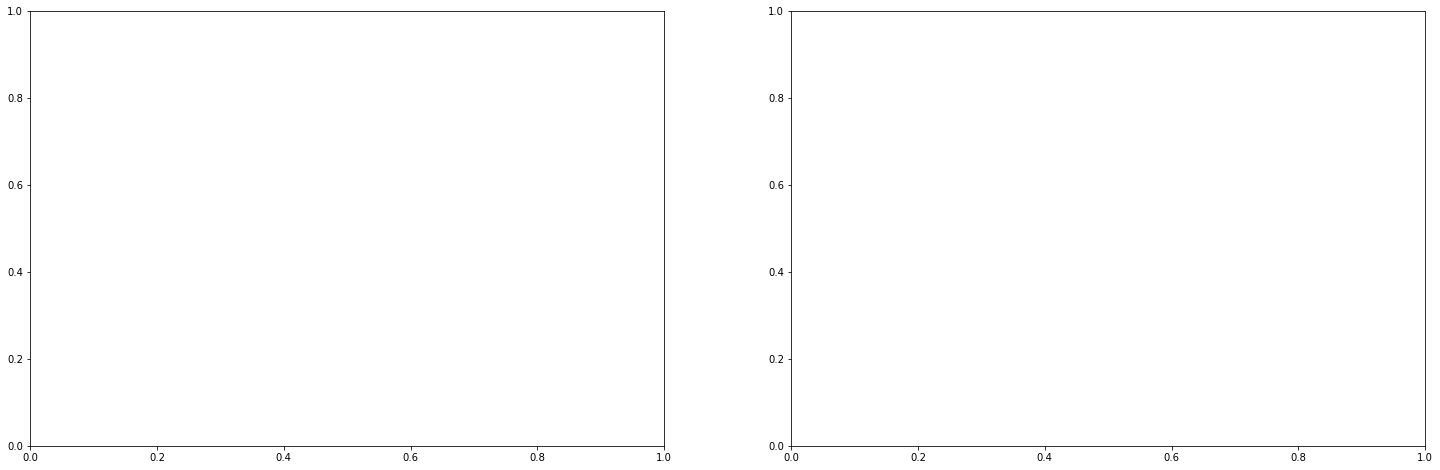

In [13]:
# Mask ASTER to study area
aster_tb_masked = aster_tb_degC.where(~np.isnan(air_tb))

# Plot both datasets
f, ax = plt.subplots(1,2,figsize=(25,8))

aster_tb_masked.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},vmin=-10,vmax=10, ax=ax[0])
ax[0].add_artist(ScaleBar(1.0))
ax[0].set_title('ASTER Surface Temperature')

air_tb_repr.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},vmin=-10,vmax=10,ax=ax[1])
ax[1].add_artist(ScaleBar(1.0))
ax[1].set_title('Reprojected Airborne Surface Temperature');